In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:43267")
client

<Client: 'tcp://127.0.0.1:43267' processes=8 threads=32, memory=125.87 GiB>

In [90]:
import numpy as np
import xarray as xr
import xrft
import os.path as op
import scipy.signal as sps
from xgcm.grid import Grid
from xmitgcm import open_mdsdataset

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
wdir = '/tank/spectre/tuchida/Line-W/'

ddir = '/tank/chaocean/qjamet/RUNS/ORAR/'
gdir = '/tank/chaocean/grid_chaO/gridMIT_update1/'
spec = '/tank/spectre/tuchida/NA-wavelets/'
savedir = '/tank/topog/tuchida/Wavelet-spectrum/'

In [15]:
ds4 = xr.open_dataset(op.join(wdir, 
                             'OS_LINE-W1_200405_D/OS_LINE-W1_200405_D_VEL.nc')
                     ).isel(DEPTH=0)
ds5 = xr.open_dataset(op.join(wdir, 
                             'OS_LINE-W1_200504_D/OS_LINE-W1_200504_D_VEL.nc')
                     ).isel(DEPTH=0)
ds6 = xr.open_dataset(op.join(wdir, 
                             'OS_LINE-W1_200604_D/OS_LINE-W1_200604_D_VEL.nc')
                     ).isel(DEPTH=0)
ds7 = xr.open_dataset(op.join(wdir, 
                             'OS_LINE-W1_200704_D/OS_LINE-W1_200704_D_VEL.nc')
                     ).isel(DEPTH=1)
ds4

<xarray.Dataset>
Dimensions:    (TIME: 17231, LATITUDE: 1, LONGITUDE: 1)
Coordinates:
  * TIME       (TIME) datetime64[ns] 2004-05-03T00:14:59.999996672 ... 2005-0...
    DEPTH      float32 2.188e+03
  * LATITUDE   (LATITUDE) float32 39.6
  * LONGITUDE  (LONGITUDE) float32 -69.72
Data variables:
    TEMP       (TIME) float32 ...
    TEMP_QC    (TIME) int8 ...
    PRES       (TIME) float32 ...
    PRES_QC    (TIME) int8 ...
    UCUR       (TIME) float32 ...
    UCUR_QC    (TIME) int8 ...
    VCUR       (TIME) float32 ...
    VCUR_QC    (TIME) int8 ...
Attributes: (12/42)
    platform_code:                 LINE-W1
    site_code:                     LINE-W
    data_mode:                     D
    title:                         LINE-W Mooring Data: Current Meters
    summary:                       Oceanographic mooring data from Line-W in ...
    naming_authority:              OceanSITES
    ...                            ...
    license:                       Follows CLIVAR(Climate Variability and Pre...
    citation:                      These data were collected and made freely ...
    acknowledgement:               Line W was begun with an initial grant fro...
    date_created:                  2017-06-02T16:20:24Z
    history:                       Mooring deployed  02-May-2004; recovered 2...
    QC_indicator:                  good_data

In [31]:
ds4.TIME, ds5.TIME, ds6.TIME, ds7.TIME

(<xarray.DataArray 'TIME' (TIME: 17231)>
 array(['2004-05-03T00:14:59.999996672', '2004-05-03T00:45:00.000000000',
        '2004-05-03T01:15:00.000003328', ..., '2005-04-26T22:15:00.057757952',
        '2005-04-26T22:45:00.057761280', '2005-04-26T23:15:00.057764608'],
       dtype='datetime64[ns]')
 Coordinates:
   * TIME     (TIME) datetime64[ns] 2004-05-03T00:14:59.999996672 ... 2005-04-...
     DEPTH    float32 2.188e+03
 Attributes:
     standard_name:     time
     long_name:         time of measurement
     axis:              T
     valid_min:         19846.010416666628
     valid_max:         20204.968750668573
     QC_indicator:      good_data
     processing_level:  Data interpolated
     comment:           Clocks were corrected for drift, and all current meter...,
 <xarray.DataArray 'TIME' (TIME: 16393)>
 array(['2005-04-30T00:14:59.999996672', '2005-04-30T00:45:00.000000000',
        '2005-04-30T01:15:00.000003328', ..., '2006-04-06T11:15:00.054948352',
        '2006-04-06T1

In [113]:
time4 = np.arange('2004-05-04', '2005-04-27', dtype='datetime64[D]')[::5]
time5 = np.arange('2005-04-30', '2006-04-06', dtype='datetime64[D]')[::5]
time6 = np.arange('2006-04-15', '2007-04-09', dtype='datetime64[D]')[::5]
time7 = np.arange('2007-04-11', '2008-01-05', dtype='datetime64[D]')[::5]
rtime = np.arange('2004-05-04', '2008-01-05', dtype='datetime64[D]')

rtime

array(['2004-05-04', '2004-05-05', '2004-05-06', ..., '2008-01-02',
       '2008-01-03', '2008-01-04'], dtype='datetime64[D]')

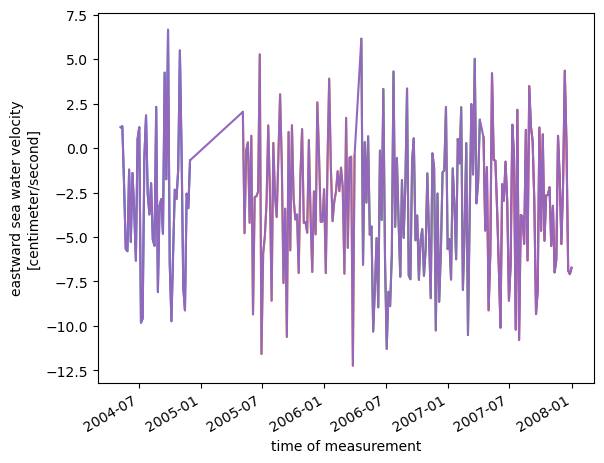

In [119]:
u4 = ds4.UCUR.where(ds4.UCUR_QC==1).dropna('TIME')
u4 = u4.rolling(TIME=239, center=True
               ).mean(skipna=True).interp(TIME=time4, method='slinear'
                                         ).dropna("TIME")
u5 = ds5.UCUR.where(ds5.UCUR_QC==1).dropna('TIME')
u5 = u5.rolling(TIME=239, center=True
               ).mean(skipna=True).interp(TIME=time5, method='slinear'
                                         ).dropna("TIME")
u6 = ds6.UCUR.where(ds6.UCUR_QC==1).dropna('TIME')
u6 = u6.rolling(TIME=239, center=True
               ).mean(skipna=True).interp(TIME=time6, method='slinear'
                                         ).dropna("TIME")
u7 = ds7.UCUR.where(ds7.UCUR_QC==1).dropna('TIME')
u7 = u7.rolling(TIME=239, center=True
               ).mean(skipna=True).interp(TIME=time7, method='slinear'
                                         ).dropna("TIME")

Wu = xr.concat([xr.concat([xr.concat([u4,u5],'TIME'),u6],'TIME'),u7],'TIME'
              ).interp(TIME=rtime, method='slinear'
                      ).interpolate_na('TIME', method='zero'
                                      ).dropna("TIME")
fiveD = 5*86400.
rsec = np.arange(0,len(Wu.TIME)*fiveD/5,fiveD/5)

fig, ax = plt.subplots()
u4.plot(ax=ax)
u5.plot(ax=ax)
u6.plot(ax=ax)
u7.plot(ax=ax)
Wu.plot(ax=ax)

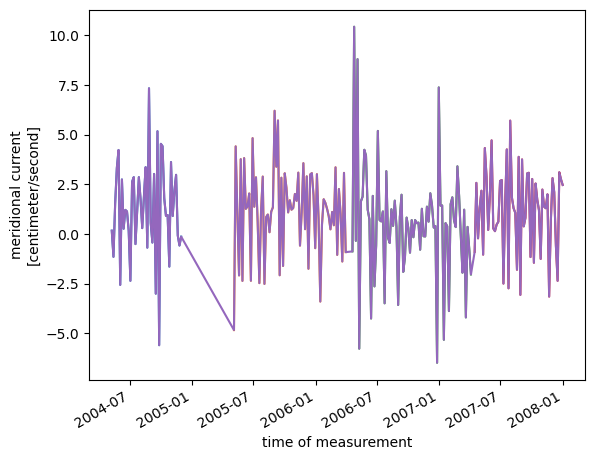

In [115]:
v4 = ds4.VCUR.where(ds4.VCUR_QC==1).dropna('TIME')
v4 = v4.rolling(TIME=239, center=True
               ).mean(skipna=True).interp(TIME=time4, method='slinear'
                                         ).dropna("TIME")
v5 = ds5.VCUR.where(ds5.VCUR_QC==1).dropna('TIME')
v5 = v5.rolling(TIME=239, center=True
               ).mean(skipna=True).interp(TIME=time5, method='slinear'
                                         ).dropna("TIME")
v6 = ds6.VCUR.where(ds6.VCUR_QC==1).dropna('TIME')
v6 = v6.rolling(TIME=239, center=True
               ).mean(skipna=True).interp(TIME=time6, method='slinear'
                                         ).dropna("TIME")
v7 = ds7.VCUR.where(ds7.VCUR_QC==1).dropna('TIME')
v7 = v7.rolling(TIME=239, center=True
               ).mean(skipna=True).interp(TIME=time7, method='slinear'
                                         ).dropna("TIME")

Wv = xr.concat([xr.concat([xr.concat([v4,v5],'TIME'),v6],'TIME'),v7],'TIME'
              ).interp(TIME=rtime, method='slinear'
                      ).interpolate_na('TIME', method='zero'
                                      ).dropna("TIME")

fig, ax = plt.subplots()
v4.plot(ax=ax)
v5.plot(ax=ax)
v6.plot(ax=ax)
v7.plot(ax=ax)
Wv.plot(ax=ax)

In [8]:
ctime = np.arange('2004-01-03', '2008-01-01', dtype='datetime64[D]')[::5]
csec = np.arange(0,len(ctime)*fiveD,fiveD)
ctime

array(['2004-01-03', '2004-01-08', '2004-01-13', '2004-01-18',
       '2004-01-23', '2004-01-28', '2004-02-02', '2004-02-07',
       '2004-02-12', '2004-02-17', '2004-02-22', '2004-02-27',
       '2004-03-03', '2004-03-08', '2004-03-13', '2004-03-18',
       '2004-03-23', '2004-03-28', '2004-04-02', '2004-04-07',
       '2004-04-12', '2004-04-17', '2004-04-22', '2004-04-27',
       '2004-05-02', '2004-05-07', '2004-05-12', '2004-05-17',
       '2004-05-22', '2004-05-27', '2004-06-01', '2004-06-06',
       '2004-06-11', '2004-06-16', '2004-06-21', '2004-06-26',
       '2004-07-01', '2004-07-06', '2004-07-11', '2004-07-16',
       '2004-07-21', '2004-07-26', '2004-07-31', '2004-08-05',
       '2004-08-10', '2004-08-15', '2004-08-20', '2004-08-25',
       '2004-08-30', '2004-09-04', '2004-09-09', '2004-09-14',
       '2004-09-19', '2004-09-24', '2004-09-29', '2004-10-04',
       '2004-10-09', '2004-10-14', '2004-10-19', '2004-10-24',
       '2004-10-29', '2004-11-03', '2004-11-08', '2004-

In [9]:
nmembs = np.concatenate((np.arange(24), np.arange(36,60)))
# nmembs = np.arange(24)

for nn in nmembs[23:]:
    
    # if nn == nmembs[0]:
    for yy in range(2004,2008):
        if nn < 36:
            fname = op.join(ddir,'memb%02d/run%4d/ocn/' % (nn,yy))
        else:
            fname = op.join(spec,'../chaocean/RUNS/orar/memb%02d/run%4d/ocn/' % (nn,yy))
        ds = open_mdsdataset(fname, 
                             grid_dir=gdir,
                             prefix=['diag_ocnTave'], delta_t=2e2,
                             # iters=iiter, 
                             # ignore_unknown_vars=True
                            ).chunk({'YC':100,'YG':100,
                                     'XC':100,'XG':100})
        grid = Grid(ds, periodic=['X'], )
        u = grid.interp(ds.UVEL,'X'
                       ).where(ds.maskC!=0.
                              ).reset_coords(drop=True
                                            ).sel(Z=-2.18e3, method='nearest'
                                                 ).sel(YC=39.6, method='nearest'
                                                      ).sel(XC=-69.7+360., 
                                                            method='nearest').load()
        v = grid.interp(ds.VVEL,'Y',boundary='extend'
                       ).where(ds.maskC!=0.
                              ).reset_coords(drop=True
                                            ).sel(Z=-2.18e3, method='nearest'
                                                 ).sel(YC=39.6, method='nearest'
                                                      ).sel(XC=-69.7+360., 
                                                            method='nearest').load()
        if yy == 2004:
            U = u
            V = v
        else:
            U = xr.concat([U,u], 'time')
            V = xr.concat([V,v], 'time')

        ds.close()
        del u, v

    U = U.drop('time')
    U = U.assign_coords({'time':ctime})
    V = V.drop('time')
    V = V.assign_coords({'time':ctime})
    
    dsave = U.to_dataset(name='U')
    dsave['V'] = V
    dsave.to_zarr(op.join(spec,'Line-W/memb%02d.zarr' % nn), mode='w')
    dsave.close()
        
#     else:
#         for yy in range(2004,2008):
#             ds = open_mdsdataset(op.join(ddir,'memb%02d/run%4d/ocn/' 
#                                          % (nn,yy)), 
#                                  grid_dir=gdir,
#                                  prefix=['diag_ocnTave'], delta_t=2e2,
#                                  # iters=iiter, 
#                                  # ignore_unknown_vars=True
#                                 )
#             u = grid.interp(ds.UVEL,'X'
#                            ).where(ds.maskC!=0.
#                                   ).reset_coords(drop=True
#                                                 ).sel(Z=-2.18e3, method='nearest'
#                                                      ).sel(YC=39.6, method='nearest'
#                                                           ).sel(XC=-69.7+360., 
#                                                                 method='nearest').load()
#             v = grid.interp(ds.VVEL,'Y',boundary='extend'
#                            ).where(ds.maskC!=0.
#                                   ).reset_coords(drop=True
#                                                 ).sel(Z=-2.18e3, method='nearest'
#                                                      ).sel(YC=39.6, method='nearest'
#                                                           ).sel(XC=-69.7+360., 
#                                                                 method='nearest').load()
#             if yy == 2004:
#                 UU = u
#                 VV = v
#             else:
#                 UU = xr.concat([UU,u], 'time')
#                 VV = xr.concat([VV,v], 'time')
                
#             ds.close()
#             del u, v
            
#         UU = UU.drop('time')
#         UU = UU.assign_coords({'time':ctime})
#         VV = VV.drop('time')
#         VV = VV.assign_coords({'time':ctime})
        
#         U = xr.concat([U,UU], 'nmemb')
#         V = xr.concat([V,VV], 'nmemb')
        
#         del UU, VV
        
U

<xarray.DataArray 'UVEL' (time: 292)>
array([-7.52492175e-02, -1.20053120e-01, -9.92403626e-02, -5.38077652e-02,
       -2.62262058e-02, -1.07951500e-02, -4.42031771e-02, -5.46066165e-02,
       -9.60098952e-02, -1.09108999e-01, -7.59347826e-02, -8.71698633e-02,
       -5.62033951e-02, -5.46141267e-02, -6.34456798e-02, -8.11228380e-02,
       -1.11879379e-01, -7.33430684e-02, -3.44531238e-02, -8.98015872e-03,
        3.46019259e-03,  9.01925471e-03, -1.54130505e-02, -3.65571566e-02,
       -7.54011720e-02, -6.48417324e-02, -1.75896045e-02, -4.65282723e-02,
       -7.35984594e-02, -6.92917407e-02, -3.38551067e-02, -3.13233361e-02,
       -2.29863450e-02, -4.89892624e-03, -5.53288385e-02, -3.92823964e-02,
       -7.41223106e-04, -8.31687525e-02, -1.10576868e-01, -5.82137629e-02,
        1.36924330e-02,  3.98553014e-02,  4.05029431e-02, -2.14786977e-02,
       -2.41800807e-02, -8.07194263e-02, -9.60070342e-02, -5.80210909e-02,
       -1.52381472e-02, -7.89523870e-03, -7.80872554e-02, -1.49051487e-01,
       -1.00655064e-01, -2.59225294e-02, -4.02949676e-02, -5.19560799e-02,
       -1.26356278e-02, -4.91490066e-02, -8.35585520e-02, -8.94781500e-02,
       -1.00229539e-01, -1.17033973e-01, -1.03721842e-01, -8.86903703e-02,
       -3.24730650e-02, -2.64322981e-02,  5.49010038e-02,  4.50557321e-02,
        9.76486481e-05, -1.11368626e-01, -1.59838349e-01, -1.51306570e-01,
       -1.08335406e-01,  1.51134292e-02,  3.03760581e-02, -7.54180253e-02,
       -6.64271116e-02, -2.95907743e-02, -9.38956290e-02, -1.63552806e-01,
...
       -5.28897420e-02, -8.06616843e-02, -6.77297786e-02, -3.29819024e-02,
       -1.64240375e-02, -2.93307081e-02, -6.05344400e-02, -1.10715993e-01,
       -1.27902716e-01, -3.64506319e-02,  1.64568443e-02, -2.27351598e-02,
       -4.07408327e-02, -7.73558915e-02, -5.20896092e-02, -6.94717839e-02,
       -1.15890011e-01, -1.01362616e-01, -4.23992351e-02, -3.85873839e-02,
       -5.22056967e-02, -2.13309638e-02, -5.15470505e-02, -5.70638850e-02,
       -4.41696122e-03,  3.65417376e-02, -4.45318408e-02, -1.02610752e-01,
       -1.36064515e-01, -7.80925751e-02,  3.04262657e-02,  2.81245876e-02,
       -8.67074877e-02, -1.56646863e-01, -1.39685839e-01, -1.07009634e-01,
       -6.89980090e-02, -4.81051728e-02, -1.45142758e-02, -6.20223880e-02,
       -6.06899038e-02, -4.23853956e-02, -2.13768538e-02, -4.27097715e-02,
       -7.48642385e-02, -4.20972928e-02, -2.81630512e-02, -4.72830757e-02,
       -4.20340896e-02, -6.38916865e-02, -7.86119252e-02, -5.97684048e-02,
       -5.54466955e-02, -5.69826439e-02, -1.12536155e-01, -7.10718706e-02,
        1.34147415e-02, -1.02973208e-02, -4.08734903e-02, -8.41757804e-02,
       -7.27610812e-02, -5.93245700e-02, -8.37228224e-02, -7.50748441e-02,
       -5.75831681e-02, -7.91686922e-02, -4.59742062e-02, -7.28312582e-02,
       -8.10811669e-02, -2.01903731e-02, -9.98917222e-03,  7.04364292e-03,
        2.48426050e-02, -5.89209981e-03, -4.90865782e-02, -2.92425230e-02],
      dtype=float32)
Coordinates:
    XC       >f4 290.3
    YC       >f4 39.58
    Z        >f4 -2.266e+03
  * time     (time) datetime64[ns] 2004-01-03 2004-01-08 ... 2007-12-28

In [12]:
nmembs = np.concatenate((np.arange(24), np.arange(36,60)))
# nmembs = np.arange(24)

for nn in nmembs[:]:
    if nn == nmembs[0]:
        ds = xr.open_zarr(op.join(spec,'Line-W/memb%02d.zarr' % nn))
    else:
        ds = xr.concat([ds, xr.open_zarr(op.join(spec,'Line-W/memb%02d.zarr' % nn))
                       ], 'nmemb')
ds

<xarray.Dataset>
Dimensions:  (nmemb: 48, time: 292)
Coordinates:
    XC       float32 290.3
    YC       float32 39.58
    Z        float32 -2.266e+03
  * time     (time) datetime64[ns] 2004-01-03 2004-01-08 ... 2007-12-28
Dimensions without coordinates: nmemb
Data variables:
    U        (nmemb, time) float32 dask.array<chunksize=(1, 292), meta=np.ndarray>
    V        (nmemb, time) float32 dask.array<chunksize=(1, 292), meta=np.ndarray>

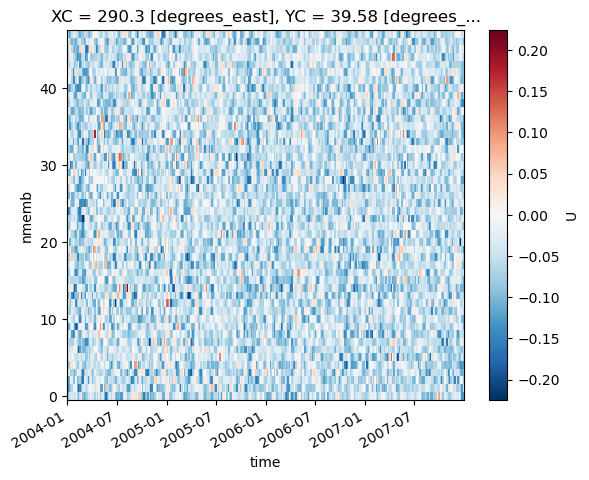

In [24]:
ds.U.plot()

In [25]:
cFu = xrft.power_spectrum(ds.U.chunk({'time':-1}
                                    ).drop('time').assign_coords({'time':csec}), 
                          dim='time', detrend='linear', 
                          window='hann', window_correction=True
      ).compute()
cFv = xrft.power_spectrum(ds.V.chunk({'time':-1}
                                    ).drop('time').assign_coords({'time':csec}), 
                          dim='time', detrend='linear', 
                          window='hann', window_correction=True
      ).compute()

In [88]:
from scipy.stats import bootstrap
datas = (.5*(cFu+cFv).where(cFu.freq_time>0.).transpose('nmemb','freq_time')
         * 2,)  # samples must be in a sequence
rng = np.random.default_rng()
Eres = bootstrap(datas, np.mean, confidence_level=0.95,
                 random_state=rng
                )

/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/scipy/stats/_resampling.py:92: DegenerateDataWarning: The bootstrap distribution is degenerate; the confidence interval is not defined.
  warnings.warn(DegenerateDataWarning(msg))


In [120]:
wFu = xrft.power_spectrum(Wu.chunk({'TIME':-1}
                                  ).drop(['TIME','DEPTH']
                                        ).assign_coords({'TIME':rsec})*1e-2, 
                          dim='TIME', detrend='linear', 
                          window='hann', window_correction=True
      ).compute()
wFv = xrft.power_spectrum(Wv.chunk({'TIME':-1}
                                  ).drop(['TIME','DEPTH']
                                        ).assign_coords({'TIME':rsec})*1e-2, 
                          dim='TIME', detrend='linear', 
                          window='hann', window_correction=True
      ).compute()

In [126]:
f, Pxx_den = sps.welch(xrft.detrend(Wu.chunk({'TIME':-1}
                                            ).drop(['TIME','DEPTH']
                                                  ).assign_coords({'TIME':rsec}),
                                    'TIME', detrend_type='linear'
                                   )*1e-2, 
                       fiveD**-1*5, detrend=None,
                       nperseg=512)
f, Pyy_den = sps.welch(xrft.detrend(Wv.chunk({'TIME':-1}
                                            ).drop(['TIME','DEPTH']
                                                  ).assign_coords({'TIME':rsec}),
                                    'TIME', detrend_type='linear'
                                   )*1e-2, 
                       fiveD**-1*5, detrend=None,
                       nperseg=512)
f, Pxx_den

(array([0.00000000e+00, 2.26056134e-08, 4.52112269e-08, 6.78168403e-08,
        9.04224537e-08, 1.13028067e-07, 1.35633681e-07, 1.58239294e-07,
        1.80844907e-07, 2.03450521e-07, 2.26056134e-07, 2.48661748e-07,
        2.71267361e-07, 2.93872975e-07, 3.16478588e-07, 3.39084201e-07,
        3.61689815e-07, 3.84295428e-07, 4.06901042e-07, 4.29506655e-07,
        4.52112269e-07, 4.74717882e-07, 4.97323495e-07, 5.19929109e-07,
        5.42534722e-07, 5.65140336e-07, 5.87745949e-07, 6.10351563e-07,
        6.32957176e-07, 6.55562789e-07, 6.78168403e-07, 7.00774016e-07,
        7.23379630e-07, 7.45985243e-07, 7.68590856e-07, 7.91196470e-07,
        8.13802083e-07, 8.36407697e-07, 8.59013310e-07, 8.81618924e-07,
        9.04224537e-07, 9.26830150e-07, 9.49435764e-07, 9.72041377e-07,
        9.94646991e-07, 1.01725260e-06, 1.03985822e-06, 1.06246383e-06,
        1.08506944e-06, 1.10767506e-06, 1.13028067e-06, 1.15288628e-06,
        1.17549190e-06, 1.19809751e-06, 1.22070313e-06, 1.243308

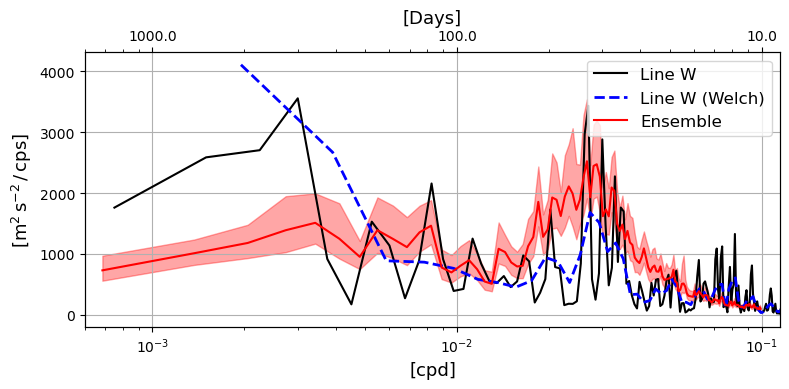

In [129]:
fig, ax = plt.subplots(figsize=(8,4))
ax2 = ax.twiny()
fig.set_tight_layout(True)

ax.fill_between(cFu.freq_time.where(cFu.freq_time>0.)*86400, 
                Eres.confidence_interval.low, 
                Eres.confidence_interval.high, 
                alpha=.35, color='r')

ax.plot(wFu.freq_TIME.where(wFu.freq_TIME>0.)*86400,
        .5*(wFu+wFv).where(wFu.freq_TIME>0.) * 2, 'k',
        label=r"Line W"
       )
ax.plot(f[1:]*86400,
        .5*(Pxx_den+Pyy_den)[1:], 'b--', lw=2,
        label=r"Line W (Welch)"
       )
ax.plot(cFu.freq_time.where(cFu.freq_time>0.)*86400,
        .5*(cFu+cFv).mean('nmemb').where(cFu.freq_time>0.) * 2, 'r',
        label=r"Ensemble"
       )

ax.set_xscale('log')
ax2.set_xscale('log')
ax.set_xlim([6e-4,1.15e-1])
ax2.set_xlim([6e-4,1.15e-1])
ax2.set_xticks([1e-3,1e-2,1e-1])
ax2.set_xticklabels([1e3,1e2,1e1])

ax.set_xlabel('[cpd]', fontsize=12)
ax.set_ylabel('[m$^2\,$s$^{-2}\,/\,$cps]', fontsize=13)
ax.set_xlabel('[cpd]', fontsize=13)
ax2.set_xlabel('[Days]', fontsize=13)
ax.grid(True)
ax.legend(loc='upper right', fontsize=12)

plt.savefig(op.join(spec,'Figs/Freq-spec_LineW.pdf'))